# Pruebas de CLICK sobre start_oo.py
Se busca probar las funciones y scripts para obtener una mayor rapidez de ejecucion. 
Basandose en la estructura como esta en start_oo.py

In [1]:
# librerias que utilizaras
import numpy as np
# por si no te lee las tools o functions creadas
import sys
# herramientas para leer pdbs
import read_pdb_tools as rpt
# calculo de distancia
from scipy.spatial.distance import pdist, squareform
# libreria de tablas
import pandas as pd
# funciones de click generadas en pandas
import funciones_CLICK as fc
# iteradores
import itertools as it
# cuenta tiempo de ejecucion
import datetime

In [2]:
# assert( len(sys.argv) > 1)
# lectura de archivo
file1 = '1xxa.pdb' # sys.argv[1]
file2 = '1tig.pdb' # sys.argv[2]

# numero de cliques, preguntar en el software para generalizarlo...
num_cliques = 3

# se define la estructura
pdb1 = rpt.PdbStruct("first")
pdb2 = rpt.PdbStruct("second")

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)
pdb2.AddPdbData("%s" % file2)

# se obtienen los residuos que perteneces a la cadena de interes por default chain = 'A'
pdb11 = pdb1.GetResChain()
pdb22 = pdb2.GetResChain()

ss1 = pdb1.Get_SS(file1)
ss2 = pdb1.Get_SS(file2)

In [3]:
# se crea atributo a cada residuo
for i, j in zip(pdb11, ss1.structure.values):
    setattr(i, 'structure', j)
for i, j in zip(pdb22, ss2.structure.values):
    setattr(i, 'structure', j)

In [4]:
def get_df_distancias(ref):
    """Funcion para obtener el dataframe de distancias de cada proteina"""
    # se generan listas con coordenadas y numero de atomo
    coord = [res.GetAtom('CA').coord for res in ref]
    index = [res.resi for res in ref]

    # calcula distancia y regresa dataframe
    distancias = []
    # se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v in coord:
        distancia_un_atomo = []
        for av in coord:
            distancia = pdist(np.array([v, av]), metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)

    # se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=index, columns=index, data=distancias)
    return(df_da, index)


df_distancias1, index1 = get_df_distancias(pdb11)
df_distancias2, index2 = get_df_distancias(pdb22)

In [5]:
# se generan cliques, tte devuleve dataframe con cliques de 3 y la lista de cliques sin partir
df_cliques1, cliques1 = fc.gen_3_cliques(df_distancias1, dth=10, k=num_cliques)
print('**'*50)
df_cliques2, cliques2 = fc.gen_3_cliques(df_distancias2, dth=10, k=num_cliques)
print('**'*50)

numero de cliques maximos encontrados: 158
numero de 3-cliques posibles: 1787
****************************************************************************************************
numero de cliques maximos encontrados: 246
numero de 3-cliques posibles: 2102
****************************************************************************************************


In [6]:
def get_df_ca(list_of_residues):
    """Genera dataframe con la informacion necesaria para las siguientes funciones
    FALTA DOCUMENTAR ESTA COSA!!!!"""
    #crear df_ca
    atom_number = []
    atom_name = []
    residue_name = []
    residue_number = []
    coord = []
    for res in list_of_residues:
        for atom in res.atoms:
            atom_number.append(atom.atom_number)
            atom_name.append(atom.name)
            residue_name.append(res.resn)
            residue_number.append(res.resi)
            coord.append(atom.coord)

    df_atoms = pd.DataFrame(columns=['atom_number', 'atom_name', 'residue_name',
                                   'residue_number', 'vector'])
    df_atoms.atom_number = atom_number
    df_atoms.atom_name = atom_name
    df_atoms.residue_name = residue_name
    df_atoms.residue_number = residue_number
    df_atoms.vector = coord

    return(df_atoms)


# CREAR DF_atomos_CA #
df_atoms1 = get_df_ca(pdb11)
df_atoms2 = get_df_ca(pdb22)

In [7]:
# se obtiene la estructura secundaria utilizando dssp
# ss1 = fc.mini_dssp(file1, index1)
# print('**'*50)
# ss2 = fc.mini_dssp(file2, index2)
# ya no por que se obtiene arriba desde read_pdb_tools.py

# se le pega la estructura secundaria al dataframe de los cliques
# esto va a cambiar por que lo tiene que obtener del objeto residuo
# ya se crea en ss1 y no cuesta reevaluar si es mejor desde el residuo
# checar que es mas rapido si desde residuo o desde dataframe ss
df_cliques1 = fc.paste_SS(ss1, df_cliques1, num_cliques = num_cliques)
df_cliques2 = fc.paste_SS(ss2, df_cliques2, num_cliques = num_cliques)

In [8]:
# comparacion SSM #aqui se obtienen los candidatos posibles pasando el filtro de SS
candidatos_ss = fc.compare_SS(df_cliques1,df_cliques2, num_cliques=num_cliques)

In [9]:
# get coords of cliques
df_cliques1 = fc.get_coords_clique(df_atoms1, df_cliques1, num_cliques)
df_cliques2 = fc.get_coords_clique(df_atoms2, df_cliques2, num_cliques)

In [10]:
# baricentro clique
df_cliques1 = fc.baricenter_clique(df_cliques1, num_cliques)
df_cliques2 = fc.baricenter_clique(df_cliques2, num_cliques)

In [11]:
# vectores gorro
df_cliques1 = fc.center_vectors(df_cliques1, num_cliques)
df_cliques2 = fc.center_vectors(df_cliques2, num_cliques)

In [12]:
for i,j in enumerate(df_cliques1.columns):
    print(i,j)

0 0
1 1
2 2
3 ss_0
4 ss_1
5 ss_2
6 coord_clique_0
7 coord_clique_1
8 coord_clique_2
9 matriz_coordenadas
10 baricentro_clique
11 vec_gorro_0
12 vec_gorro_1
13 vec_gorro_2
14 vectores_gorro


In [13]:
idx_rmsd1, idx_rmsd2 = 3*num_cliques, 4*num_cliques+3
# print(list(range(idx_rmsd1,idx_rmsd2)))
# se pasan a numpy arrays para mayor rapidez
array_df_cliques1 = df_cliques1.values[:, range(idx_rmsd1, idx_rmsd2)] #del 9 al 15
array_df_cliques2 = df_cliques2.values[:, range(idx_rmsd1, idx_rmsd2)]

In [14]:
#calculo del RMSD
print(len(candidatos_ss))

1705808


# Prueba distancia minima entre el centro de cada esfera promedio

In [15]:
# # el baricentro de los vectores gorro es el origen
# algo = fc.baricenter_vectores_gorro(df_cliques1,num_cliques)
# algo2 = fc.baricenter_vectores_gorro(df_cliques2,num_cliques)

In [16]:
# #se pasan de cartesianas a polares
# def cart2pol(x, y,z):
#     rho = np.sqrt(x**2 + y**2 + z**2)
#     phi = np.arctan2(y, x)
#     return(rho, phi)

# def pol2cart(rho, phi):
#     x = rho * np.cos(phi)
#     y = rho * np.sin(phi)
#     return(x, y)

In [17]:
import cufflinks as cf
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# algo.head(2)

In [73]:
#PLOT DE COMO SE VEN LOS ATOMOS AL COMPARAR
trace1 = go.Scatter3d(
    x=np.array(algo.vectores_gorro[0])[:,0],
    y=np.array(algo.vectores_gorro[0])[:,1],
    z=np.array(algo.vectores_gorro[0])[:,2],
    mode='markers+lines',
    marker=dict(
        size=12,
        line=dict(
#             color='rgba(0, 0, 153, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x=np.array(algo2.vectores_gorro[0])[:,0],
    y=np.array(algo2.vectores_gorro[0])[:,1],
    z=np.array(algo2.vectores_gorro[0])[:,2],
    mode='markers+lines',
    marker=dict(
#         color='rgb(102, 102, 0)',
        size=12,
        symbol='circle',
        line=dict(
#             color='rgb(204, 204, 0)',
            width=1
        ),
        opacity=0.9
    )
)
trace3 = go.Scatter3d(
    x=np.array(algo.matriz_coordenadas[0])[:,0],
    y=np.array(algo.matriz_coordenadas[0])[:,1],
    z=np.array(algo.matriz_coordenadas[0])[:,2],
    mode='markers+lines',
    marker=dict(
        size=12,
        line=dict(
#             color='rgba(0, 0, 153, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace4 = go.Scatter3d(
    x=np.array(algo2.matriz_coordenadas[0])[:,0],
    y=np.array(algo2.matriz_coordenadas[0])[:,1],
    z=np.array(algo2.matriz_coordenadas[0])[:,2],
    mode='markers+lines',
    marker=dict(
#         color='rgb(102, 102, 0)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 0)',
            width=1
        ),
        opacity=0.9
    )
)
trace5 = go.Scatter3d(
    x=np.array(0),
    y=np.array(0),
    z=np.array(0),
    mode='markers+lines',
    marker=dict(
#         color='rgb(102, 102, 0)',
        size=6,
        symbol='square',
        line=dict(
            color='rgb(204, 204, 0)',
            width=1
        ),
        opacity=0.9
    )
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter',)

# Codigo que compara candidatos

In [19]:
%%time
restriccion_rmsd = 0.15
if num_cliques == 4:
    restriccion_rmsd = 0.30
if num_cliques == 5:
    restriccion_rmsd = 0.60
if num_cliques == 7:
    restriccion_rmsd = 1.50
if num_cliques == 8:
    restriccion_rmsd = 1.80

candidatos = [(i, j) for i, j in candidatos_ss if fc.calculate_rmsd_rot_trans(
    i, j, array_df_cliques1, array_df_cliques2, num_cliques) <= restriccion_rmsd]

# rmsd_candidatos = [fc.calculate_rmsd_rot_trans(i, j, array_df_cliques1, array_df_cliques2, num_cliques) for i, j in candidatos_ss if fc.calculate_rmsd_rot_trans(
#     i, j, array_df_cliques1, array_df_cliques2, num_cliques) <= restriccion_rmsd]

print('numero de candidatos:', len(candidatos))

numero de candidatos: 6907
CPU times: user 4min 59s, sys: 444 ms, total: 4min 59s
Wall time: 4min 59s


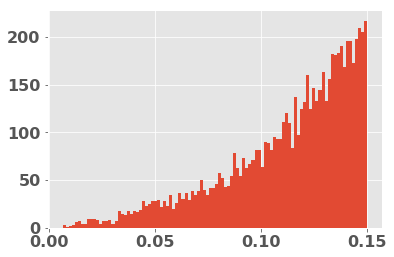

In [78]:
pd.Series(rmsd_candidatos).hist(bins=100)

In [79]:
pd.Series(rmsd_candidatos).describe()

count   6907.00000
mean    0.11314   
std     0.03040   
min     0.00648   
25%     0.09610   
50%     0.12134   
75%     0.13724   
max     0.15000   
dtype: float64

In [82]:
pd.Series(rmsd_candidatos).quantile(0.1)

0.06727038032400437

In [83]:
pd.Series(rmsd_candidatos).quantile(0.05)

0.05001109786292722

In [136]:
pd.Series(rmsd_candidatos).quantile(0.01)

0.02523522209157175

In [90]:
candimans = pd.DataFrame([candidatos,rmsd_candidatos]).T

In [94]:
candimans.columns = ['candidatos','rmsd']

In [103]:
candimans['cand1'] = candimans.candidatos.str[0]
candimans['cand2'] = candimans.candidatos.str[1]

In [110]:
candimans.rmsd = candimans.rmsd.astype(float)

In [129]:
esto = candimans.groupby(['cand1','cand2']).rmsd.mean()

In [176]:
esto[esto < 0.05]

cand1  cand2
17     1220    0.04090
33     363     0.03582
       1018    0.03242
       1081    0.01528
       1173    0.04195
       2058    0.04083
59     1476    0.01657
70     1159    0.00963
       1532    0.02959
189    1242    0.02918
190    1295    0.03836
222    1442    0.01339
230    1276    0.04978
312    1745    0.03645
338    1366    0.04759
345    144     0.04983
350    960     0.03699
376    1442    0.03475
436    974     0.04434
449    1437    0.02963
456    594     0.04411
463    1442    0.02424
       1777    0.01154
468    1442    0.01876
       1777    0.03447
       1885    0.03777
478    957     0.02572
480    1269    0.03776
493    135     0.01925
       138     0.04154
       139     0.03550
503    1160    0.04858
       1455    0.02191
504    1494    0.03899
506    3       0.02229
       14      0.00648
       114     0.03423
       363     0.01066
       491     0.04921
       1018    0.02251
       2058    0.01366
511    1754    0.03529
515    587     0.0492

In [209]:
serie_rmsd = pd.Series(rmsd_candidatos)
q5 = pd.Series(rmsd_candidatos).quantile(0.05)
q10 = pd.Series(rmsd_candidatos).quantile(0.1)
q20 = pd.Series(rmsd_candidatos).quantile(0.2)

q5count = serie_rmsd[serie_rmsd <=q5].count()
q10count = serie_rmsd[serie_rmsd <=q10].count()
q20count = serie_rmsd[serie_rmsd <=q20].count()


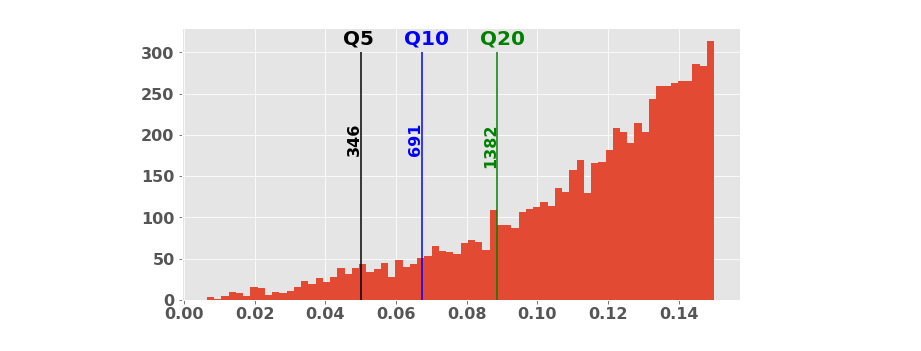

In [219]:
serie_rmsd.hist(bins=70,figsize = (10,5))
plt.title('Distribucion de rmsd de candidatos despues de comparacion para encontrar corte optimo', color='w',fontsize= 20)
plt.vlines(q5,0,300)
plt.text(q5-0.005,310,'Q5', fontsize=20)
plt.text(q5-0.004, 200,q5count, fontsize=16,rotation=90)
plt.vlines(q10,0,300, color = 'b')
plt.text(q10-0.005,310,'Q10',color = 'b',fontsize=20)
plt.text(q10-0.004, 200,q10count, fontsize=16,rotation=90, color='b')
plt.vlines(q20,0,300, color ='g')
plt.text(q20-0.005,310,'Q20',color = 'g',fontsize=20)
plt.text(q20-0.004, 200,q20count, fontsize=16,rotation=90,color='g')
plt.xlabel('RMSD', color='w')
plt.savefig('distribucion_rmsd.jpg')

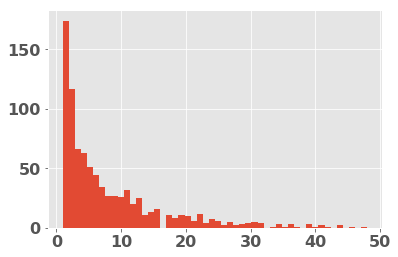

In [225]:
candimans.cand1.value_counts().hist(bins =50)

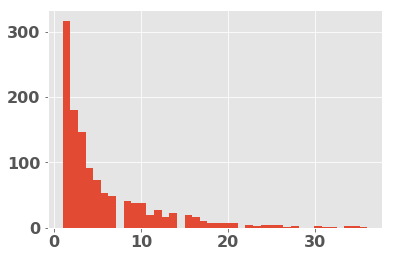

In [230]:
candimans.cand2.value_counts().hist(bins =40)

In [19]:
pd.Series(candidatos_ss).to_csv('candidatos_ss.csv')

# Haciendo MUltiprocessing

In [16]:
# import random, time, multiprocessing
 
# def func(arg):
#     print ('%s says %s'%(multiprocessing.current_process(), arg))
#     time.sleep( random.uniform(0, 0.5) )
#     return arg
 
# p     = multiprocessing.Pool(5)
 
# result1 = p.map_async( func, range(100,199) )
# result2 = p.map_async( func, range(200,299) )
# result3 = p.map_async( func, range(300,399) )
 
# print ("Waiting for results")
 
# p.close()
# p.join()
# print (result1.get())
# print (result2.get())

In [17]:
len(candidatos_ss)/3

568602.6666666666

In [18]:
568602 + 568602

1137204

In [19]:
primer_cacho = candidatos_ss

In [20]:
import multiprocessing
from functools import partial

In [21]:
cacho_1 = primer_cacho[:568602]
cacho_2 = primer_cacho[568602:1137204]
cacho_3 = primer_cacho[1137204:]

In [22]:
p = multiprocessing.Pool()

In [56]:
%%time
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), cacho_1)
rmsd_2 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), cacho_2)
rmsd_3 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), cacho_3)

CPU times: user 26.2 s, sys: 1.03 s, total: 27.2 s
Wall time: 1min 30s


In [57]:
# %%time #para map_async
# a = rmsd_1.get()
# b = rmsd_2.get()
# c = rmsd_3.get()

In [58]:
multiprocessing.cpu_count()

8

In [61]:
f1 = pd.DataFrame(rmsd_1)
f2 = pd.DataFrame(rmsd_2)
f3 = pd.DataFrame(rmsd_3)

In [63]:
f = pd.concat([f1,f2,f3])

In [70]:
f = f[f[0] <=0.15]

In [74]:
f[1].values

array([(10, 616), (10, 1085), (10, 1403), ..., (1780, 1759), (1781, 147),
       (1781, 1305)], dtype=object)